In [14]:
# size dist plus growth rates
import numpy as np

import matplotlib.pyplot as plt
import seaborn
% matplotlib inline
from scipy.stats import norm

import pandas as pd

from scipy.special import erf


In [269]:
# Plan.


# from size dist and N, I should have n(q, Q). 

# The size dists are:
#  - Lognormal clipped x > 3. 
sigma = 1.3149476902828778
mu = 4.470439741406725

# 13% of guys that would be below the .3 threshold.
z = (mu - 3)/sigma
cum_th = 1 - .5*(1 + erf(z/np.sqrt(2)))

#  - Pareto on the 90% value, small percent of 

### Empirical number of agents and total value
Recommendation: 

1e5 agents. 

~1e11.5 EUR annually 

In [ ]:
data_path = './../../data/processed/'

df = pd.read_csv('./../../data/processed/ID_Y.csv')
df = df.loc[df.IMPORT == 0]
empirical = df.groupby(['YEAR']).agg({'ID': 'count', 'VART': 'sum'}) # count == nunique

In [318]:
# We'll try different N's, until we can match the avg level of France imports 

tot_val = []
Ns = np.array(np.round(np.power(10, np.arange(4.5, 5.5, .01))), dtype = int)

for N in Ns:
    N_ = int(round(N/(1 - cum_th))) # We use a larger N ..
    draw = np.random.normal(mu, sigma, N_) # so that approximately we'll have N guys above x = 3
    draw = np.sort(draw)[-N:]
    tot_val += [np.power(10, draw).sum()] # (=y)

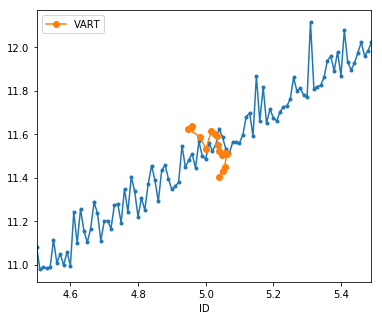

In [319]:
fig, ax = plt.subplots(1, figsize = (6, 5))

ax.plot(np.log10(Ns), np.log10(tot_val), marker = '.')
np.log10(empirical).plot('ID', 'VART', marker = 'o', ax = ax)
plt.show()
# *think that mu, sigma are for pooled data, but they could be different in each year.

In [ ]:
# growth rates

In [322]:
N = int(1e5)
N_ = int(round(N/(1 - cum_th))) # We use a larger N ..
draw = np.random.normal(mu, sigma, N_) # so that approximately we'll have N guys above x = 3
draw = np.sort(draw)[-N:]

In [335]:
# From the theoretical N and the ppf we can know the theoretical quantiles
N_
x1 = np.array([norm.ppf(q, mu, sigma) for q in np.arange(0, 1, 1/N_) + .5/N_])
x1 = x1[(-N - 1):-1]

In [359]:
# Now we can have the n(Q, q)
def get_n(x1, Q):
    x_lin = np.power(10, x1)
    bins = pd.cut(pd.Series(np.cumsum(x_lin)), Q)
    ns = bins.value_counts().values
    return bins, ns

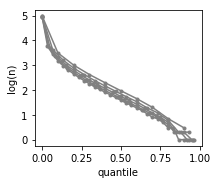

In [385]:
fig, ax = plt.subplots(1, figsize = (3, 2.5))

for Q in [10, 15, 20, 25, 30]:
    ax.plot(np.arange(Q)/Q, np.log10(get_n(Q)), marker = '.', c = '.5')
plt.xlabel('quantile')
plt.ylabel('log(n)')
plt.show()


## Empirical GR

In [439]:
gr_info = pd.read_csv('./../../data/processed/g_rates_info.csv')

In [415]:
x0 = pd.Series(draw)
g_rates_list = []

# size dependent growth rates
for s in np.arange(3, 10.5, .5):
    x0_s = x0.loc[abs(x0 - s) < .25]
    gr_s = gr_info.loc[abs(gr_info.level - s) < .5]  
    
    g_rates_long = gr_s.sample(len(x0_s) * int(T/2), replace = True)
    g_rates = g_rates_long[['logdiff1', 'logdiff2']].values.reshape(len(x0_s), T)
    g_rates_list += [g_rates]
    
g_rates = pd.DataFrame(np.vstack(g_rates_list))

# If T is made many x T we could have repetitions with little effort...

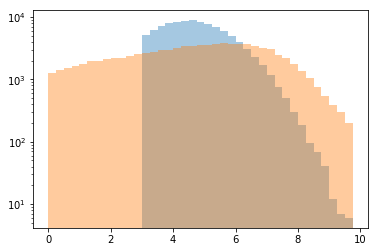

In [437]:
plt.hist(x0.values, np.arange(0, 10, .25), alpha = .4)
plt.hist(x0.values + g_rates.cumsum(axis = 1)[15], np.arange(0, 10, .25), alpha = .4)
plt.yscale('log')
plt.show()

In [ ]:
# There is some issue, distribution gets deformed over time.

## Modeled GR
- Non correlated
    - Gaussian (a = 2)
    - Laplace (a = 1)
    - Subbotin (a = 1/2)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


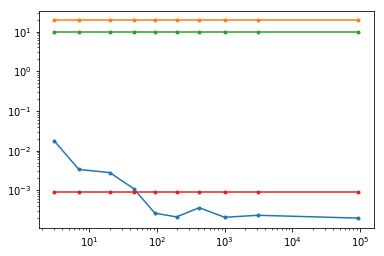

In [564]:
# x0 = pd.Series(draw)
# x1 is the exact distribution
Q = 10
bins, ns = get_n(x1, Q)

# size dependent growth rates
sigma = .3
I = 1000

var_result = []
for i in range(I):
    if i%10 == 0: print(i)
    g_rates = np.random.normal(0, sigma, (N, T)) # # If T is made many x T we could have repetitions with little effort...

    gr_cs = g_rates.cumsum(axis = 1)
    gr_cs = (gr_cs.T - gr_cs.mean(axis = 1)).T
    xt = (gr_cs.T + x1).T

    st = np.power(10, xt)
    lin_levs = pd.DataFrame(st, index = bins)
    bin_ix_mapper = dict(zip(bins.unique(), range(bins.nunique())))
    lin_levs.index = lin_levs.index.map(bin_ix_mapper); lin_levs.index.name = 'q'

    # see if quantiles tend to have more or less a constant part ofthe value
    # df.groupby(level = 0).sum().reset_index(drop = True).T.plot()

    # The sum of this simulated quantile q, Q, i
    lin_levs_i = lin_levs.groupby(level = 0).sum()
    # The key line. # Variance of each quantile. 
    out_df = lin_levs_i
    out_df['var_qi'] = np.log10(lin_levs_i).var(axis = 1)
    out_df['i'] = i
    out_df['Q'] = Q
    out_df['var_agg_i'] = np.log10(lin_levs.sum()).var()
    var_result += [out_df]

result = pd.concat(var_result).reset_index()
result.to_csv('./../../data/processed/exp_var_norm_1s_s'+str(sigma)+'.csv', index = False)

# Histogram of size dist diffusion
# plt.hist(x1, np.arange(0, 10, .1), alpha = .4)
# plt.hist(xt[:, 15], np.arange(0, 10, .1), alpha = .4)
# plt.yscale('log')
# plt.show()

plt.plot(ns, var_qi, marker = '.')
plt.xscale('log')
plt.yscale('log')